# Placement Demo

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import gpflow

from gpflow import default_float
from gpflow.ci_utils import ci_niter

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

f64 = gpflow.utilities.to_default_float

In [98]:
# Function to be learned:
def f(X):
    return np.sin(X) - np.sin(10*X)/5

In [99]:
# Constants
obs_noise = 0.01
min_X = 0
max_X = 10
n_current = 100
n_pool = 5
n_test = 200
n_inducing = 40

In [100]:
# X coordinates
X_curr = np.random.uniform(min_X, max_X, (n_current, 1))
X_pool = np.random.uniform(min_X, max_X, (n_pool, 1))

X_test = np.linspace(min_X, max_X, n_test)
X_test = X_test.reshape((n_test, 1))

# Inducing points
Z = np.linspace(min_X, max_X, n_inducing)
Z = Z.reshape((n_inducing, 1))

# Y values
Y_curr = f(X_curr) + np.random.normal(0, obs_noise, X_curr.shape)
Y_pool = f(X_pool) + np.random.normal(0, obs_noise, X_pool.shape)
Y_test = f(X_test) # No noise added to test/reference points

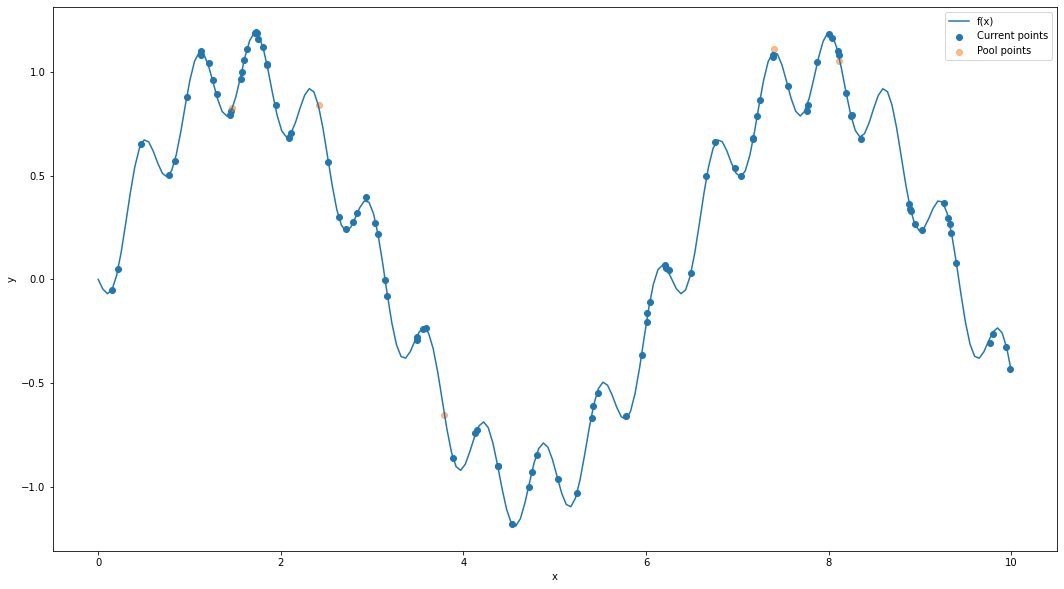

In [101]:
plt.figure(figsize=(18, 10))
plt.scatter(X_curr, Y_curr, label = 'Current points')
plt.scatter(X_pool, Y_pool, alpha = 0.5, label = 'Pool points')
plt.plot(X_test, Y_test, label = 'f(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

In [121]:
curr_data = (X_curr, Y_curr)
kernel = gpflow.kernels.Matern52()
model = gpflow.models.SGPMC(curr_data, kernel, gpflow.likelihoods.Gaussian(), inducing_variable=Z)
model

name,class,transform,prior,trainable,shape,dtype,value
SGPMC.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPMC.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SGPMC.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPMC.inducing_variable.Z,Parameter,Identity,,True,"(40, 1)",float64,[[0....
SGPMC.V,Parameter,Identity,Normal,True,"(40, 1)",float64,[[0....


In [122]:
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(0.5))
model.kernel.variance.prior = tfd.Gamma(f64(0.5), f64(1.0))
model.likelihood.variance.prior = tfd.Gamma(f64(0.1), f64(1.0))

model.likelihood.variance.assign(0.001)

minibatch_size = n_inducing

# We turn off training for inducing point locations
gpflow.utilities.set_trainable(model.inducing_variable.Z, False)

def optimise(model, iterations):
    optimiser = tf.optimizers.Adam(0.01)
    training_loss = model.training_loss_closure(compile=True)

    @tf.function
    def optimization_step():
        optimiser.minimize(training_loss, model.trainable_variables)
        
    for i in range(iterations):
        optimization_step()
    
optimise(model, 20000)
model

name,class,transform,prior,trainable,shape,dtype,value
SGPMC.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,2.510892503216008
SGPMC.kernel.lengthscales,Parameter,Softplus,Gamma,True,(),float64,0.768800878348867
SGPMC.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.0013926313053660494
SGPMC.inducing_variable.Z,Parameter,Identity,,False,"(40, 1)",float64,[[0....
SGPMC.V,Parameter,Identity,Normal,True,"(40, 1)",float64,[[-0.15299025...


In [123]:
f_samples_map = model.predict_f_samples(X_test, 25000)

In [124]:
num_samples = 10000
num_burnin_steps = 1000

@tf.function
def run_chain_fn(model, num_samples, num_burnin_steps, num_leapfrog_steps = 5, step_size = 0.02):
    num_samples = ci_niter(num_samples)
    num_burnin_steps = ci_niter(num_burnin_steps)
    
    hmc_helper = gpflow.optimizers.SamplingHelper(
        model.log_likelihood_lower_bound, model.trainable_parameters
    )
    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=num_leapfrog_steps, step_size=step_size
    )
    adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
        hmc, num_adaptation_steps=1500, target_accept_prob=f64(0.75), adaptation_rate=0.01
    )
        
    unconstrained_samples, trace = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results = 10,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )
    
    parameter_samples = hmc_helper.convert_to_constrained_values(unconstrained_samples)
    
    return unconstrained_samples, parameter_samples, trace

samples, parameter_samples, trace = run_chain_fn(model, num_samples, num_burnin_steps)

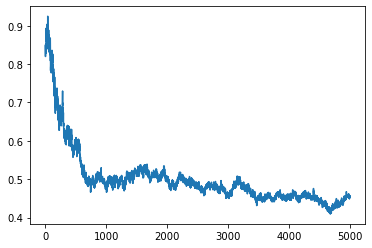

In [110]:
plt.plot(parameter_samples[1])

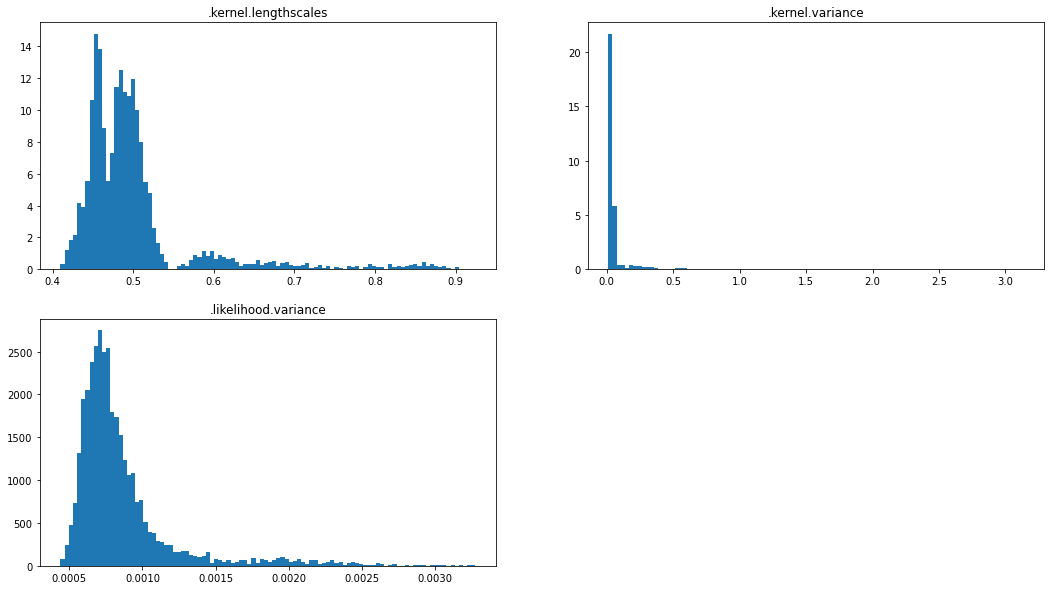

In [111]:
param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
param_to_name[model.trainable_parameters[0]]

plt.figure(figsize = (18, 10))
plt.subplot(221)
plt.hist(parameter_samples[1].numpy(), 100, density=True)
plt.title(param_to_name[model.trainable_parameters[1]])
plt.subplot(222)
plt.hist(parameter_samples[2].numpy(), 100, density=True)
plt.title(param_to_name[model.trainable_parameters[2]])
plt.subplot(223)
plt.hist(parameter_samples[3].numpy(), 100, density=True)
plt.title(param_to_name[model.trainable_parameters[3]]);

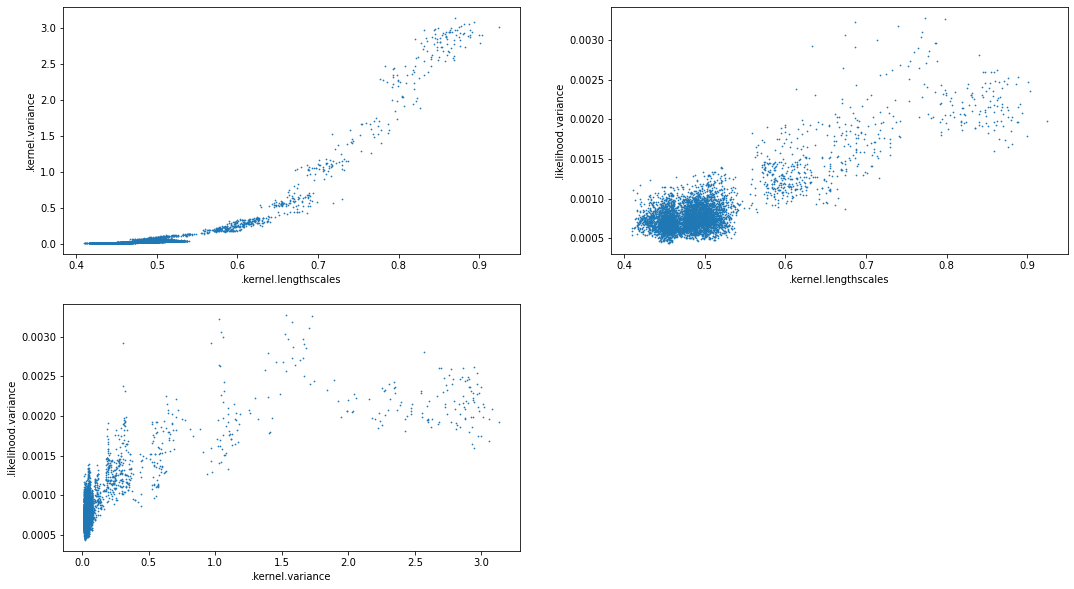

In [112]:
plt.figure(figsize = (18, 10))
plt.subplot(221)
plt.scatter(parameter_samples[1].numpy(), parameter_samples[2].numpy(), 0.5)
plt.xlabel(param_to_name[model.trainable_parameters[1]])
plt.ylabel(param_to_name[model.trainable_parameters[2]])
plt.subplot(222)
plt.scatter(parameter_samples[1].numpy(), parameter_samples[3].numpy(), 0.5)
plt.xlabel(param_to_name[model.trainable_parameters[1]])
plt.ylabel(param_to_name[model.trainable_parameters[3]])
plt.subplot(223)
plt.scatter(parameter_samples[2].numpy(), parameter_samples[3].numpy(), 0.5)
plt.xlabel(param_to_name[model.trainable_parameters[2]])
plt.ylabel(param_to_name[model.trainable_parameters[3]])
plt.show()

In [113]:
f_samples = []

for i in range(num_samples):
    # Note that hmc_helper.current_state contains the unconstrained variables
    for var, var_samples in zip(model.trainable_parameters, parameter_samples):
        var.assign(var_samples[i])
    f_batch = model.predict_f_samples(X_test, 5)
    f_samples.append(f_batch)
f_samples_marg = np.vstack(f_samples)
np.random.shuffle(f_samples_marg)

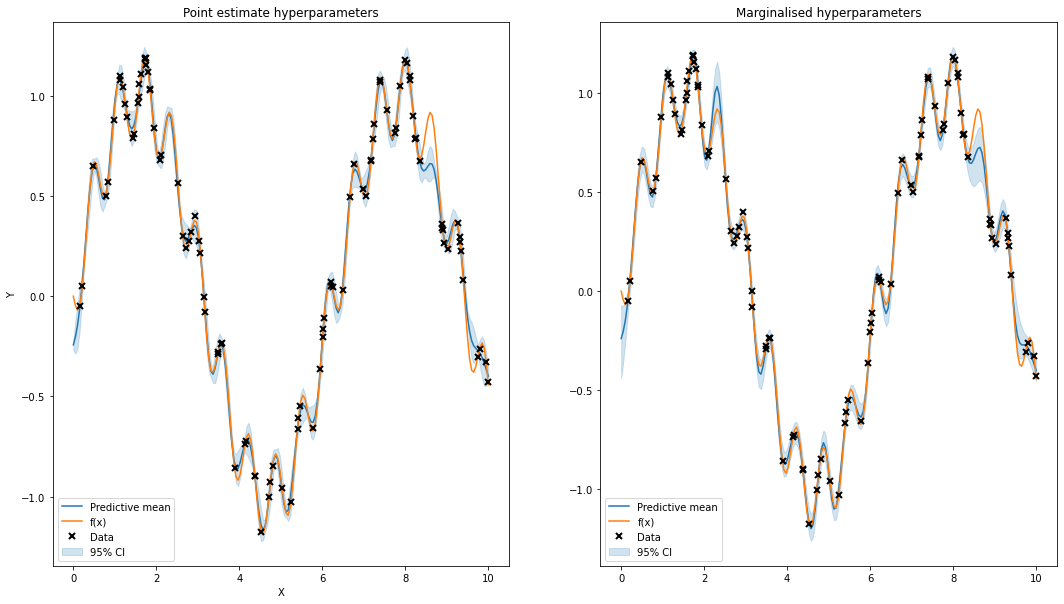

In [114]:
plt.figure(figsize=(18, 10))

plt.subplot(121)
plt.title('Point estimate hyperparameters')
(line_map,) = plt.plot(X_test, np.mean(f_samples_map, 0), label='Predictive mean')
plt.fill_between(
    X_test[:, 0],
    np.percentile(np.squeeze(f_samples_map), 2.5, axis=0),
    np.percentile(np.squeeze(f_samples_map), 97.5, axis=0),
    color=line_map.get_color(),
    alpha=0.2,
    label='95% CI'
)
plt.plot(X_test, Y_test, label='f(x)')
plt.plot(X_curr.flatten(), Y_curr.flatten(), "kx", mew=2, label='Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(122)
plt.title('Marginalised hyperparameters')
(line_marg,) = plt.plot(X_test, np.mean(f_samples_marg, 0), label='Predictive mean')
"""for i in range(25):
    plt.plot(Xtest, f_samples[i, :], 0.01)"""
plt.fill_between(
    X_test[:, 0],
    np.percentile(np.squeeze(f_samples_marg), 2.5, axis=0),
    np.percentile(np.squeeze(f_samples_marg), 97.5, axis=0),
    color=line_marg.get_color(),
    alpha=0.2,
    label='95% CI'
)
plt.plot(X_test, Y_test, label='f(x)')
plt.plot(X_curr.flatten(), Y_curr.flatten(), "kx", mew=2, label='Data')
plt.legend()

plt.show()

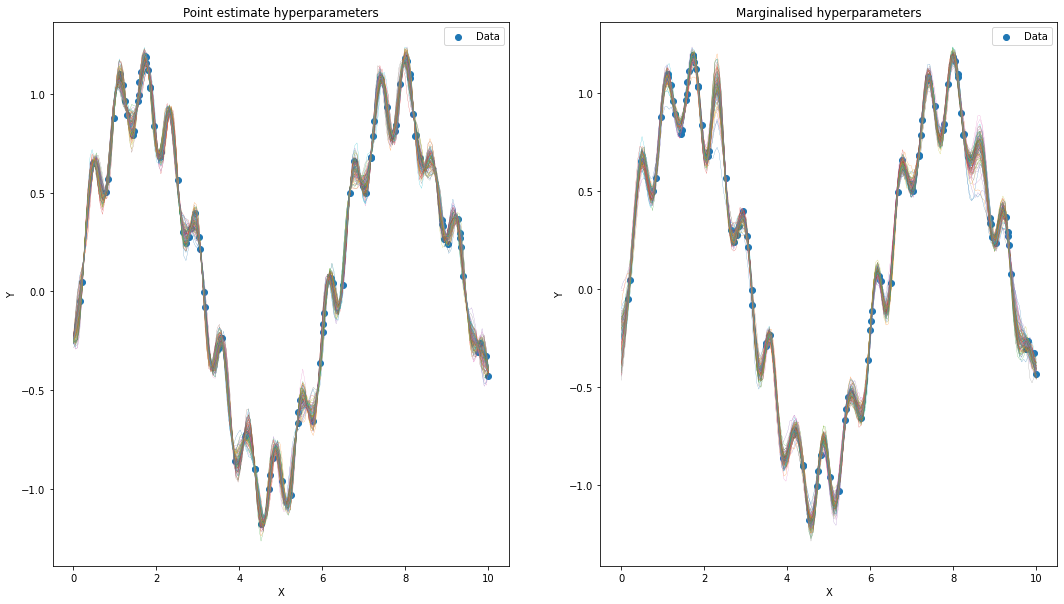

In [115]:
plt.figure(figsize=(18, 10))

plt.subplot(121)
plt.title('Point estimate hyperparameters')
for i in range(100):
    plt.plot(X_test, f_samples_map[i], lw = 0.2);
plt.scatter(X_curr, Y_curr, label = 'Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.subplot(122)
plt.title('Marginalised hyperparameters')
for i in range(100):
    plt.plot(X_test, f_samples_marg[i], lw = 0.2);
plt.scatter(X_curr, Y_curr, label = 'Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

Metric for evaluating the performance of the samples, actual value not as important as the improvement.

In [73]:
def RMSE(Y_test, f_samples):
    num_f_samples = f_samples.shape[0]
    error = np.concatenate([Y_test - f_samples[i, :, :] for i in range(num_f_samples)])
    mse = np.mean(error**2)
    rmse = np.sqrt(mse)
    return rmse

In [74]:
RMSE(Y_test, f_samples_marg)

0.07278409585033248

In [75]:
RMSE(Y_test, f_samples_map)

0.049134480958690635

Evaluate the improvement after placement of a sensor:

In [76]:
def predict_f_samples_marg(X, model, parameter_samples, num_f_samples = None):
    '''Function to get f_samples from marginalised hyperparameters'''
    num_parameter_samples = parameter_samples[0].shape[0]
    if num_f_samples is None or num_f_samples < num_parameter_samples: # Default: draws a single sample from each hyperparameter configuration.
        num_f_samples_per_hp = 1
    else:
        num_f_samples_per_hp = num_f_samples//num_parameter_samples
    f_samples = []
    for i in range(num_samples):
        for var, var_samples in zip(model.trainable_parameters, parameter_samples):
            var.assign(var_samples[i])
        f_samples_given_parameters = model.predict_f_samples(X, num_f_samples_per_hp)
        f_samples.append(f_samples_given_parameters)
    f_samples = np.vstack(f_samples)
    return f_samples

In [77]:
def place_by_var(X_pool, f_samples):
    '''Decides sensor placement by variance at that point'''
    score = np.var(f_samples, 0)
    return score

In [78]:
def place_by_range(X_pool, f_samples):
    ''''''
    score = np.max(f_samples, 0) - np.min(f_samples, 0)
    return score

In [79]:
def placement(model, X_pool, placement_func, parameter_samples = None, num_f_samples = None, func_kwargs_dict = dict()):
    '''Gives the ranked placements by model predictive variance
    
    This is a wrapper function which draws the samples of f and then evaluates the sensor 
    placements according to the criteria passed to it.
    If parameter_samples is not given then the model parameters should be optimised.
    Args:
        X_pool: n x D matrix of the n potential new sensor locations
        model: a GPflow regression model
        placement_func: function which maps samples from f at X_pool to some metric representing suitability for new sensor location.
            Should take X_pool, f_samples as the two parameters.
        parameter_samples: a tuple of tensorflow tensors containing hyperparameters of the GP, sampled from the
            marginal likelihood.
        num_f_samples: the number of times f should be sampled at each of the pool points.
    Returns:
        an list of the indices of X_pool in order of sensor placement priority.
    '''
    assert parameter_samples is not None or num_f_samples is not None, 'At least one of parameter_samples or num_f_samples should be specified'
    if parameter_samples is None: # Draw all the f samples from the single point estimate model.
        f_samples = model.predict_f_samples(X_pool, num_f_samples)
    else: # Draws each sample of f from a different point estimate
        f_samples = predict_f_samples_marg(X_pool, model, parameter_samples, num_f_samples)
    scores = placement_func(X_pool, f_samples, **func_kwargs_dict)
    order = np.argsort(scores, 0)
    return order

order, f_samples = placement(X_pool, model, place_by_var, parameter_samples, 5000)

AttributeError: 'numpy.ndarray' object has no attribute 'trainable_parameters'

In [ ]:
def bootstrap_EI(model, X_pool):
    X_curr, Y_curr = model.data
    

In [ ]:
def add_model_data(model, new_data):
    X_curr, Y_curr = model.data
    X, Y = new_data
    X_curr = X_curr.numpy()
    Y_curr = Y_curr.numpy()
    X_new = np.concatenate((X_curr, X))
    Y_new = np.concatenate((Y_curr, Y))
    model.data = (tf.constant(X_new), tf.constant(Y_new))

In [ ]:
def improvement(model, X_pool, Y_pool, X_test, Y_test, num_hp_samples, num_hp_burnin, num_f_samples):
    _, parameter_samples, _ = run_chain_fn(model, num_samples, num_burnin_steps)
    f_samples_marg = predict_f_samples_marg(X_test, model, parameter_samples)
    pre_placement_error = RMSE(Y_test, f_samples_marg)
    
    order = placement(model, X_pool, place_by_var, parameter_samples)
    new_data = (X_pool[order[0]], Y_pool[order[0]])
    add_model_data(model, new_data)
    post_placement_error